In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import scipy.io as sio
import scipy.optimize as opt
from sklearn.metrics import classification_report

In [2]:
def load_data(path, transpose=True):
    data = sio.loadmat(path)
    y = data.get('y')          # (5000,1)
    y = y.reshape(y.shape[0])  # make it back to column vector 2dim -> 1dim

    X = data.get('X')  # (5000,400)

    if transpose:
        # for this dataset, you need a transpose to get the orientation right
        X = np.array([im.reshape((20, 20)).T for im in X])

        # and I flat the image again to preserve the vector presentation
        X = np.array([im.reshape(400) for im in X])

    return X, y

In [4]:
x, y = load_data('ex3data1.mat')

print(x.shape)
print(y.shape)

(5000, 400)
(5000,)


In [5]:
def plot_an_image(image):
#     """
#     image : (400,)
#     """
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.matshow(image.reshape((20, 20)), cmap=matplotlib.cm.binary)  # 400pixels to 20x20
    plt.xticks(np.array([]))  # just get rid of ticks
    plt.yticks(np.array([]))

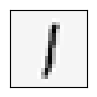

this should be 1


In [6]:
pick_one = np.random.randint(0, 5000)
plot_an_image(x[pick_one, :])
plt.show()
print('this should be {}'.format(y[pick_one]))  # the data in 'y'

## Visualize the data

In [7]:
def plot_100_image(X):
    size = int(np.sqrt(X.shape[1])) # turn into a square image
    
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100) # randomly choose 100 images
    sample_images = X[sample_idx, :]
    
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))#plot the images
    
    for r in range(10):
        for c in range(10):
            ax_array[r,c].matshow(sample_images[10*r+c].reshape(size, size), cmap=matplotlib.cm.binary)
            
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

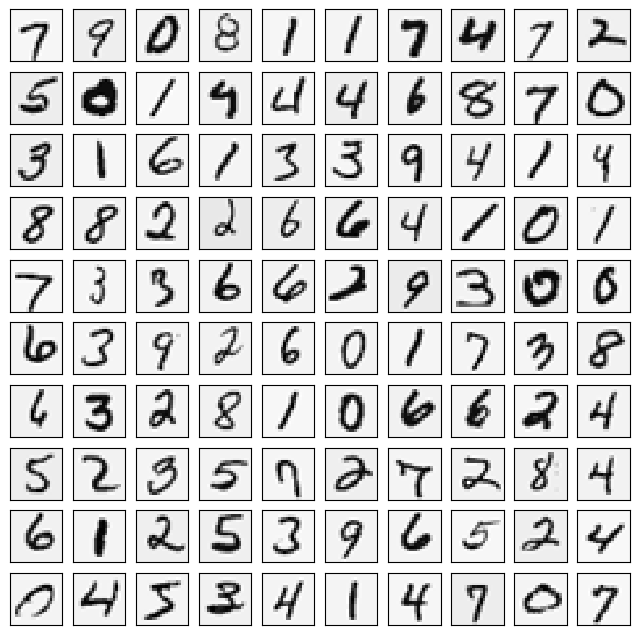

In [9]:
plot_100_image(x)
plt.show()

In [10]:
raw_X, raw_y = load_data('ex3data1.mat')
print(raw_X.shape)
print(raw_y.shape)

(5000, 400)
(5000,)


## Prepare data

In [11]:
# add intercept=1 for x0
X = np.insert(raw_X, 0, values=np.ones(raw_X.shape[0]), axis=1)#插入了第一列（全部为1）
X.shape

(5000, 401)

In [12]:
# y have 10 categories here. 1..10, they represent digit 0 as category 10 because matlab index start at 1
# x:0 y:10
y_matrix = []

for k in range(1, 11):
    y_matrix.append((raw_y == k).astype(int)) 
    
# last one is k==10, it's digit 0, bring it to the first position.
y_matrix = [y_matrix[-1]] + y_matrix[:-1] 
y = np.array(y_matrix) 

y.shape

(10, 5000)

In [13]:
y

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1]])

# train 1-dim model

## Cost function
$$
J(\theta)=\frac{1}{m} \sum_{i=1}^{m}\left[-y^{(i)} \log \left(h_{\theta}\left(x^{(i)}\right)\right)-\left(1-y^{(i)}\right) \log \left(1-h_{\theta}\left(x^{(i)}\right)\right)\right]
$$

In [14]:
def cost(theta, X, y):
    return np.mean(-y * np.log(sigmoid(X @ theta)) - (1 - y) * np.log(1 - sigmoid(X @ theta)))

## Regularized cost function

In [15]:
def regularized_cost(theta, X, y, l=1): # l is lambda
    '''you don't penalize theta_0'''
    theta_j1_to_n = theta[1:]
    regularized_term = (l / (2 * len(X))) * np.power(theta_j1_to_n, 2).sum() 

    return cost(theta, X, y) + regularized_term

## Regularized gradient descent
$$
\begin{aligned} \frac{\partial J(\theta)}{\partial \theta_{0}} &=\frac{1}{m} \sum_{i=1}^{m}\left(h_{\theta}\left(x^{(i)}\right)-y^{(i)}\right) x_{j}^{(i)} \quad \text { for } j=0 \\ \frac{\partial J(\theta)}{\partial \theta_{j}} &=\left(\frac{1}{m} \sum_{i=1}^{m}\left(h_{\theta}\left(x^{(i)}\right)-y^{(i)}\right) x_{j}^{(i)}\right)+\frac{\lambda}{m} \theta_{j} \quad \text { for } j \geq 1 \end{aligned}
$$

In [16]:
def regularized_gradient(theta, X, y, l=1):
    '''still, leave theta_0 alone'''
    theta_j1_to_n = theta[1:]
    regularized_theta = (l / len(X)) * theta_j1_to_n

    # by doing this, no offset is on theta_0
    regularized_term = np.concatenate([np.array([0]), regularized_theta])#np.concatenate（）：数组拼接函数

    return gradient(theta, X, y) + regularized_term

# sigmoid function
 \\[g\left( z \right)=\frac{1}{1+{{e}^{-z}}}\\] 
	\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 

In [17]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## Gradient descent
$$
\frac{\partial J}{\partial \theta_{j}}=\frac{1}{m} \sum_{i=1}^{m}\left(\left(h_{\theta}\left(x^{(i)}\right)-y^{(i)}\right) x_{j}^{(i)}\right)
$$

In [18]:
def gradient(theta, X, y):
    '''just 1 batch gradient'''
    return (1 / len(X)) * X.T @ (sigmoid(X @ theta) - y)

In [19]:
def logistic_regression(X, y, l=1):
    """generalized logistic regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization

    return: trained parameters
    """
    # init theta
    theta = np.zeros(X.shape[1]) # create 0s vector in the same length with X's

    # train it
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'disp': True}) 
    # get trained parameters
    final_theta = res.x

    return final_theta

In [20]:
def predict(x, theta):
    prob = sigmoid(x @ theta)
    return (prob >= 0.5).astype(int)

In [21]:
t0 = logistic_regression(X, y[0])

In [22]:
print(t0.shape)
y_pred = predict(X, t0)
print('Accuracy={}'.format(np.mean(y[0] == y_pred)))

(401,)
Accuracy=0.9974


## train k-dim model

In [23]:
k_theta = np.array([logistic_regression(X, y[k]) for k in range(10)])
print(k_theta.shape)

(10, 401)


## Prediction

* think about the shape of k_theta, now you are making $X\times\theta^T$
> $(5000, 401) \times (10, 401).T = (5000, 10)$
* after that, you run sigmoid to get probabilities and for each row, you find the highest prob as the answer

In [24]:
prob_matrix = sigmoid(X @ k_theta.T)

In [25]:
np.set_printoptions(suppress=True) #打印全部函数
prob_matrix

array([[0.99577541, 0.        , 0.00053548, ..., 0.0000647 , 0.00003909,
        0.0017185 ],
       [0.9983453 , 0.0000001 , 0.00005611, ..., 0.0000968 , 0.0000029 ,
        0.00008478],
       [0.99139857, 0.        , 0.00056831, ..., 0.00000655, 0.02654076,
        0.00197138],
       ...,
       [0.00000068, 0.04139254, 0.00321027, ..., 0.00012724, 0.00297292,
        0.70750396],
       [0.00001843, 0.00000013, 0.00000009, ..., 0.00164745, 0.06819205,
        0.86121496],
       [0.02883343, 0.        , 0.00012983, ..., 0.36622109, 0.00497645,
        0.14826777]])

In [26]:
prob_matrix[0]

array([0.99577541, 0.        , 0.00053548, 0.00011997, 0.00000016,
       0.00154185, 0.00003355, 0.0000647 , 0.00003909, 0.0017185 ])

In [27]:
y_pred = np.argmax(prob_matrix, axis=1)

# np.argmax() return the index of the max
y_pred

array([0, 0, 0, ..., 9, 9, 7], dtype=int64)

In [28]:
y_answer = raw_y.copy()
y_answer[y_answer == 10] = 0

In [29]:
print(classification_report(y_answer, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       500
           1       0.95      0.99      0.97       500
           2       0.95      0.92      0.93       500
           3       0.95      0.91      0.93       500
           4       0.95      0.95      0.95       500
           5       0.92      0.92      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.93      0.92      0.92       500
           9       0.92      0.92      0.92       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



# Neural Network

In [30]:
def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'], data['Theta2']

In [31]:
theta1, theta2 = load_weight('ex3weights.mat')

theta1.shape, theta2.shape

((25, 401), (10, 26))

In [32]:
X, y = load_data('ex3data1.mat',transpose=False) # do not transpose here

X = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1)  

X.shape, y.shape

((5000, 401), (5000,))

## feed forward prediction
![](https://i.loli.net/2019/08/25/evE9DU4gdrRlBYA.png)

In [34]:
a1=X

z2 = np.dot(a1, theta1.T)

z2.shape

(5000, 25)

In [35]:
z2=np.insert(z2, 0, values=np.ones(X.shape[0]), axis=1)
z2.shape

(5000, 26)

In [36]:
a2=sigmoid(z2)
z3=np.dot(a2,theta2.T)
z3.shape

(5000, 10)

In [37]:
a3=sigmoid(z3)
a3

array([[0.00013825, 0.0020554 , 0.00304012, ..., 0.00049102, 0.00774326,
        0.99622946],
       [0.00058776, 0.00285027, 0.00414688, ..., 0.00292311, 0.00235617,
        0.99619667],
       [0.00010868, 0.0038266 , 0.03058551, ..., 0.07514539, 0.0065704 ,
        0.93586278],
       ...,
       [0.06278247, 0.00450406, 0.03545109, ..., 0.0026367 , 0.68944816,
        0.00002744],
       [0.00101909, 0.00073436, 0.00037856, ..., 0.01456166, 0.97598976,
        0.00023337],
       [0.00005908, 0.00054172, 0.0000259 , ..., 0.00700508, 0.73281465,
        0.09166961]])

In [38]:
y_pred = np.argmax(a3, axis=1) + 1  # numpy is 0 base index, +1 for matlab convention
y_pred.shape

(5000,)

In [39]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.97      0.98      0.97       500
           2       0.98      0.97      0.97       500
           3       0.98      0.96      0.97       500
           4       0.97      0.97      0.97       500
           5       0.98      0.98      0.98       500
           6       0.97      0.99      0.98       500
           7       0.98      0.97      0.97       500
           8       0.98      0.98      0.98       500
           9       0.97      0.96      0.96       500
          10       0.98      0.99      0.99       500

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

